<a href="https://colab.research.google.com/github/VRehnberg/MCDropProp/blob/main/MCDropPropSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Installations
This code runs on the default Google Colab libraries with a few extra additions.

In [ ]:
%%bash
pip install transformers==3.3.1
pip install bayesian_optimization

     |████████████████████████████████| 1.1MB 7.5MB/s 
     |████████████████████████████████| 890kB 26.5MB/s 
     |████████████████████████████████| 1.2MB 35.0MB/s 
     |████████████████████████████████| 3.0MB 54.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=b35427feae6a4f07cbf90ea8d98de3afb3a3635c9c5a79b37c1dd0e39ada85e2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=3551c2c22901a36c4b4ee643f97621813089da4394cb98bcdd0300f1456ad4d3
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


### Loading data


In [ ]:
%%bash
if [ ! -f tools.tgz ]; then gdown --id 16JxIRBjVI3Z9ciJQIUXEvoG85Sx_3FsQ; fi
if [ ! -f ptc-corpus.tgz ]; then gdown --id 1dYjA8GJgmwIBQo2sWKMHsKhmIP1enoTD; fi
if [ ! -f baselines.tgz ]; then gdown --id 1o5srH6sKlctgr8Db35oLy7qrtdhhk42C; fi

tar zxf tools.tgz
tar zxf ptc-corpus.tgz
tar zxf baselines.tgz
ls

Downloading...
From: https://drive.google.com/uc?id=16JxIRBjVI3Z9ciJQIUXEvoG85Sx_3FsQ
To: /content/tools.tgz
100% 131k/131k [00:00<00:00, 45.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dYjA8GJgmwIBQo2sWKMHsKhmIP1enoTD
To: /content/ptc-corpus.tgz
100% 1.28M/1.28M [00:00<00:00, 85.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1o5srH6sKlctgr8Db35oLy7qrtdhhk42C
To: /content/baselines.tgz
100% 16.2k/16.2k [00:00<00:00, 25.4MB/s]
baseline-output-SI.txt	baseline-task-TC.py	      sample_data
baseline-output-TC.txt	datasets		      tools.tgz
baselines.tgz		propaganda-techniques-scorer
baseline-task-SI.py	ptc-corpus.tgz


### Imports

In [ ]:
# General imports
import os
import sys
import time
import numpy as np
import random
import warnings
from glob import glob
from tqdm.auto import tqdm, trange
from itertools import tee
from collections import defaultdict

# Tokenization
import nltk
from nltk.tokenize import WordPunctTokenizer
nltk.download("punkt")

# Word encoding
import gensim.downloader
from gensim.models import KeyedVectors
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel

# ML
import torch
import torchtext
from torch import nn, optim
from bayes_opt import BayesianOptimization

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 140
%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1. Reading the data


In [ ]:
def read_data(
    dataset_name,
    fields,
    tokenizer,
    max_len,
    lowercase,
    additional_data=False,
    test_data=False,
    verbose=True,
):
    '''Function to format dataset'''

    base_tokenizer = WordPunctTokenizer()

    # Format dataset
    examples = []
    n_truncated = 0
    for article_path in tqdm(glob(f"datasets/{dataset_name}-articles/article*.txt")):
        # Read article information
        article_id = int(article_path[26 + len(dataset_name) : -4])

        with open(article_path, mode="r", encoding="utf-8") as article_file:
            article_str = article_file.read()
            article_file.seek(0)
            article_lines = article_file.readlines()
        article_chr_len = len(article_str)

        # Get SI character sequences
        if not test_data:
            label_si_path_prefix = f"datasets/{dataset_name}-labels-task-si/article"
            label_si_path = label_si_path_prefix + f"{article_id}.task-si.labels"
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning, append=1)
                label_si_data = np.atleast_2d(
                    np.genfromtxt(label_si_path, delimiter="\t", dtype=int),
                )
        else:
            label_si_data = np.atleast_2d([])

        # Get TC character sequences
        if not test_data:
            label_flc_tc_path_prefix = f"datasets/{dataset_name}-labels-task-flc-tc/article"
            label_flc_tc_path = label_flc_tc_path_prefix + f"{article_id}.task-flc-tc.labels"
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning, append=1)
                label_tc_data = np.atleast_2d(
                    np.genfromtxt(label_flc_tc_path, delimiter="\t", dtype=str),
                )
                if label_tc_data.size > 0:
                    label_tc_data = label_tc_data[:, 1]
        else:
            label_tc_data = np.array([])

        # Tokenize sentence but remember chr numbers from raw article
        sentence_chr_start = 0
        for sentence_id, sentence in enumerate(article_lines):

            if not sentence or not base_tokenizer.tokenize(sentence):
                sentence_chr_start += len(sentence)
                continue
            
            if lowercase:
                sentence = sentence.lower()

            tokens = []
            tokens_start = []
            tokens_stop = []
            labels_si = []
            labels_tc = []
            for token, chr_span in zip(
                base_tokenizer.tokenize(sentence),
                base_tokenizer.span_tokenize(sentence),
            ):
                # Add token
                tokens.append(token)
                
                # Add indices to indicate token position in original string
                token_start, token_stop = chr_span
                token_start += sentence_chr_start
                token_stop += sentence_chr_start

                tokens_start.append(token_start)
                tokens_stop.append(token_stop)

                # Verify token_start and token_stop
                original_str = article_str[token_start : token_stop]
                if lowercase:
                    original_str = original_str.lower()

                if token != original_str:
                    print(f"{token} ≠ {original_str}")
                    raise RuntimeError("Token does not match original string.")

                # Add gold labels
                label_si = False if label_si_data.size==0 else np.any(
                    np.logical_and(
                        label_si_data[:, 1] <= token_start,
                        token_stop <= label_si_data[:, 2],
                    )
                )
                labels_si.append(label_si)
    
                if label_si:
                    i_tc_label = np.argmax(  # get label index
                        np.logical_and(
                            label_si_data[:, 1] <= token_start,
                            token_stop <= label_si_data[:, 2],
                        )
                    )
                    
                    label_tc = label_tc_data[i_tc_label]
                    #if (
                    #    (i_tc_label == 0)
                    #    or (last_label == "O")
                    #    or (last_label[1:] != label_tc)
                    #):
                    #    # If beginning of label
                    #    label_tc = "B-" + label_tc
                    #else:
                    #    # If not beginning of label
                    #    label_tc = "I-" + label_tc
                    last_label = label_tc
                        
                else:
                    # If no label
                    label_tc = "O"
                    last_label = "O"
                
                labels_tc.append(label_tc)

            # If using additional tokenizer for sub-word tokens.
            if tokenizer:
                extended_tokens = []
                extended_tokens_start = []
                extended_tokens_stop = []
                extended_labels_si = []
                extended_labels_tc = []
                for (
                    token,
                    token_start,
                    token_stop,
                    label_si,
                    label_tc,
                ) in zip(
                    tokens,
                    tokens_start,
                    tokens_stop,
                    labels_si,
                    labels_tc,
                ):
                    # Tokens
                    tmp_tokens = tokenizer.tokenize(token)
                    n_tmp = len(tmp_tokens)
                    if n_tmp==0:
                        continue
                    extended_tokens.extend(tmp_tokens)
                    
                    # Token spans
                    if n_tmp > 1:
                        word_len = token_stop - token_start
                        n_chr = [len(tmp) for tmp in tmp_tokens]
                        bert_lengths = [
                            n - 2 if i_tmp > 1 else n
                            for i_tmp, n in enumerate(n_chr)
                        ]
                        if sum(n_chr) ==  word_len:
                            # Assuming tokenization doesn't change #chrs
                            subword_spans = np.cumsum([token_start] + n_chr)
                        elif sum(bert_lengths) == word_len:
                            # Assuming BERT tokenisation with ## indicators
                            subword_spans = np.cumsum([token_start] + bert_lengths)
                        else:
                            # Other spans approx prop to subword len
                            subword_spans = token_start + np.round(
                                word_len * np.cumsum([0] + n_chr) / sum(n_chr)
                            ).astype(int)
                        extended_tokens_start.extend(subword_spans[:-1])
                        extended_tokens_stop.extend(subword_spans[1:])
                    else:
                        extended_tokens_start.append(token_start)
                        extended_tokens_stop.append(token_stop)
                    
                    # Labels SI
                    extended_labels_si.extend(n_tmp * [label_si])
                    
                    # Labels TC
                    if label_tc[0] == "B":
                        extended_labels_tc.append(label_tc)
                        extended_labels_tc.extend((n_tmp - 1) * [label_tc])
                    else:
                        extended_labels_tc.extend(n_tmp * [label_tc])

                # Extend lists to complete lists
                tokens = extended_tokens
                tokens_start = extended_tokens_start
                tokens_stop = extended_tokens_stop
                labels_si = extended_labels_si
                labels_tc = extended_labels_tc
            
            # For BERT, we need to truncate the sentences...
            if len(tokens) > max_len-2:
                tokens = tokens[:max_len-2]
                tokens_start = tokens_start[:max_len-2]
                tokens_stop = tokens_stop[:max_len-2]
                labels_si = labels_si[:max_len-2]
                labels_tc = labels_tc[:max_len-2]
                n_truncated += 1

            # Add example
            if additional_data:
                additional_field = torchtext.data.Field(
                    use_vocab=False,
                    init_token=-1,
                    eos_token=-1,
                    pad_token=-1,
                    sequential=True,
                    batch_first=True,
                )
                all_fields = [
                    ("article_id", additional_field),
                    fields[0], # words
                    ("words_start", additional_field),
                    ("words_stop", additional_field),
                    *fields[1:], # labels
                ]
                data = [
                    [article_id],
                    tokens,
                    tokens_start,
                    tokens_stop,
                    labels_si,
                    labels_tc,
                ]
                if any(len(d) != len(tokens) for d in data[1:]):
                    raise RuntimeError("Data not equal length.")
            else:
                all_fields = fields
                data = [
                    tokens,
                    labels_si,
                    labels_tc,
                ]

            examples.append(torchtext.data.Example.fromlist(data, all_fields))

            sentence_chr_start += len(sentence)

    # Collect data
    if verbose:
        print(f"Read {len(examples)} {dataset_name} sentences, truncated {n_truncated}.")
    dataset = torchtext.data.Dataset(examples, all_fields)

    return dataset

## 2. The sentence encoder

The same sentence encoder will be used in all tasks.

In [ ]:
class SentenceEncoder(nn.Module):

    def __init__(self, word_field, gensim_model, conf):        
        super().__init__()
        
        # Create a word embedding layer using the auxiliary function defined below.
        self.word_embedding = make_embedding_layer(word_field, gensim_model, conf)

        word_dim = self.word_embedding.weight.shape[1]
        
        # RNN layer
        if conf.rnn_size > 0 and conf.rnn_depth > 0:
            self.word_rnn = nn.GRU(
                input_size=word_dim,
                hidden_size=conf.rnn_size,
                num_layers=conf.rnn_depth,
                batch_first=True,
                dropout=conf.rnn_dropout_prob if conf.rnn_depth > 1 else 0,
                bidirectional=True,
            )
            self.output_size = 2*conf.rnn_size
        else:
            self.word_rnn = None
            self.output_size = word_dim 
        
        # Word dropout and final dropout
        self.word_dropout_prob = conf.word_dropout_prob
        self.embedding_dropout = nn.Dropout(p=conf.embedding_dropout_prob)
        self.output_dropout = nn.Dropout(p=conf.rnn_dropout_prob)

    def word_dropout(self, words):
        # Adapted from *Transition-based parsing* notebook
        # Randomly replace some of the positions in the word tensor with a zero.
        # This solution is a bit hacky because we assume that zero corresponds to the "unknown" token.
        w_dropout_mask = (torch.rand(size=words.shape, device=words.device) > self.word_dropout_prob).long()
        return words*w_dropout_mask

    def forward(self, words):
        # - words is a LongTensor of shape (n_sentences, n_words)

        if self.training:
            words = self.word_dropout(words)

        word_repr = self.word_embedding(words)
        # word_repr has shape (n_sentences, n_words, word_embedding_dim)

        word_repr = self.embedding_dropout(word_repr)

        if self.word_rnn:
            rnn_output, rnn_hidden = self.word_rnn.forward(word_repr)
            output = rnn_output
            # output has shape (n_sentences, n_words, 2*rnn_size)
        else:
            output = word_repr        
        
        # Dropout on output layer
        output = self.output_dropout(output)

        return output
        

In [ ]:
class BertSentenceEncoder(nn.Module):

    def __init__(self, bert_model, conf):
        super().__init__()

        self.bert_model = bert_model
        self.output_size = self.bert_model.config.hidden_size

        # Word dropout and final dropout
        self.word_dropout_prob = conf.word_dropout_prob
        self.embedding_dropout = nn.Dropout(p=conf.embedding_dropout_prob)

    def word_dropout(self, words):
        # Adapted from *Transition-based parsing* notebook
        # Randomly replace some of the positions in the word tensor with a zero.
        # This solution is a bit hacky because we assume that zero corresponds to the "unknown" token.
        w_dropout_mask = (torch.rand(size=words.shape, device=words.device) > self.word_dropout_prob).long()
        return words*w_dropout_mask
    
    def forward(self, words):

        if self.training:
            words = self.word_dropout(words)

        output = self.bert_model(words)[0]

        output = self.embedding_dropout(output)

        return output


## 3. Using gensim to load pre-trained word embeddings 

The following two auxiliary functions help us load gensim models and to convert them for use with torchtext.

In [ ]:
def make_embedding_layer(word_field, gensim_model, conf):

    if gensim_model:
        vectors, voc, _ = gensim_model
        # We assume that there are special symbols for unknown, beginning, end, pad.
        n_specials = 4
        word_field.vocab.itos = word_field.vocab.itos[:n_specials] + voc
        word_field.vocab.stoi = defaultdict(word_field.vocab.stoi.default_factory)
        for i, w in enumerate(word_field.vocab.itos):
            word_field.vocab.stoi[w] = i
        emb_dim = vectors.shape[1]
    else:
        emb_dim = conf.default_emb_dim
    
    emb_layer = nn.Embedding(len(word_field.vocab), emb_dim)
    if not conf.finetune_w_emb:
        # If we don't fine-tune, create a tensor where we don't compute the gradients.
        emb_layer.weight = nn.Parameter(emb_layer.weight, requires_grad=False)

    if gensim_model:
        with torch.no_grad():
            # Copy the pre-trained embedding weights into our embedding layer.
            emb_layer.weight[n_specials:, :] = vectors
        
    return emb_layer

In [ ]:
def load_gensim_vectors(model_file, builtin=False, limit=None):

    print(f"Loading model '{model_file}' via gensim...", end='')
    sys.stdout.flush()
    if builtin:
        gensim_model = gensim.downloader.load(model_file)
    else:
        gensim_model = KeyedVectors.load_word2vec_format(model_file, binary=True, limit=limit)
    if not limit:
        limit = len(gensim_model.index2word)
    vectors = torch.FloatTensor(gensim_model.vectors[:limit])
    voc = gensim_model.index2word[:limit]

    is_cased = False
    for w in voc:
        w0 = w[0]
        if w0.isupper(): #w0.isascii() and w0.isupper():
            is_cased = True
            break

    print(' done!')
    return vectors, voc, is_cased


## 4. Span identification neural network

Adding a binary classifier on top of the word embedding.

In [ ]:
class BinaryClassifier(nn.Module):
    
    def __init__(self, encoder, conf):
        super().__init__()

        self.encoder = encoder

        # Build si output part
        layers = []
        previous_layer_size = encoder.output_size
        for layer_size in conf.si_hidden_layers:
            layers.extend([
                nn.Linear(previous_layer_size, layer_size),
                nn.ReLU(),
                nn.Dropout(p=conf.si_dropout_prob),
            ])
            previous_layer_size = layer_size
        self.binary_classifier = nn.Sequential(
            *layers,
            nn.Linear(previous_layer_size, 1),
            nn.Sigmoid(),
        )

        # Loss function that we will use during training.
        self.loss = nn.BCELoss()

        # Prediction threshold
        self.predict_threshold = conf.predict_threshold
        self.predict_quantile = conf.predict_quantile

        # If use Monte Carlo dropout
        self.use_mcdrop = conf.use_mcdrop

    def compute_outputs(self, words):
        # We call the encoder to create contextualized word representations.
        # This will be a tensor of shape (n_sentences, n_words, encoder_output_size).
        encoded = self.encoder(words)

        # Apply the output layers.
        # The shape of the output tensor is (n_sentences, n_words).
        return self.binary_classifier(encoded).view(*encoded.shape[:-1])

    def forward(self, words, labels):
        # Computes the output scores and then the loss function.
        
        # First compute the outputs. The shape is (n_sentences, n_words, n_labels).
        scores = self.compute_outputs(words)

        # Flatten the outputs and the gold-standard labels, to compute the loss.
        # The input to this loss needs to be one 1-dimensional and one 1-dimensional tensor.
        scores = scores.view(-1)
        labels = labels.view(-1)
        return self.loss(scores, labels.to(torch.float32))

    def predict(self, words, n_evaluations=1):
        # Compute the outputs from the linear units.
        list_of_scores = [
            self.compute_outputs(words)
            for i_eval in range(n_evaluations)
        ]
        scores = np.quantile(list_of_scores, self.predict_quantile, axis=0)
        
        # Select the top-scoring labels. The shape is now (n_sentences, n_words).
        predicted = (scores > self.predict_threshold).to(torch.long)

        # We convert this output to a NumPy matrix. (This is mainly for compatibility with torchcrf.)
        return predicted.detach().cpu().numpy()

    def eval(self):
        f'''Overridden eval to enable MC dropout.
        
        Original docstring:
        {super().eval.__doc__}
        '''
        super().eval()
        if self.use_mcdrop:
            for module in self.modules():
                if module.__class__.__name__.startswith('Dropout'):
                    module.train()
        return self
        

In [ ]:
class SpanIdentifier():
    
    def __init__(self, config, gensim_model=None, bert_model_name=None, verbose=True):
        self.config = config
        self.gensim_model = gensim_model
        self.bert_model_name = bert_model_name
        
        # Some heuristics to try to determine whether we need to convert sentences to lowercase.
        if bert_model_name:
            lowercase = 'uncased' in bert_model_name
            if verbose:
                print('Lowercased BERT model?', lowercase)
        elif gensim_model:
            lowercase = not gensim_model[2]
            if verbose:
                print('Pre-trained word embedding shape:', gensim_model[0].shape)
                print('Lowercased embeddings?', lowercase)
        else:
            if verbose:
                print('No pre-trained word embedding model given.')
            lowercase = False
        
        self.lowercase = lowercase

        if bert_model_name:
            # If we're using BERT, then let's use its tokenizer, and the special tags it relies on:
            # [CLS] at the beginning of the sentence, [SEP] at the end, and [PAD] for padding.
            try:
                self.tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
            except ValueError as e:
                self.tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=lowercase)

            pad = self.tokenizer.pad_token           
            self.WORD = torchtext.data.Field(
                init_token=self.tokenizer.cls_token,
                eos_token=self.tokenizer.sep_token, 
                sequential=True,
                lower=False,#lowercase,
                unk_token=self.tokenizer.unk_token,
                pad_token=pad,
                batch_first=True,
            )
        else:
            pad = '<pad>'
            self.tokenizer = WordPunctTokenizer()
            self.WORD = torchtext.data.Field(
                init_token='<bos>',
                eos_token='<eos>',
                sequential=True,
                lower=False,#lowercase,
                pad_token='<pad>',
                unk_token='<unk>',
                batch_first=True,
            )
        
        self.LABEL_SI = torchtext.data.Field(
            is_target=True,
            use_vocab=False,
            init_token=False,
            eos_token=False,
            pad_token=False,
            sequential=True,
            unk_token=None,
            batch_first=True,
        )
        self.LABEL_TC = torchtext.data.Field(
            is_target=True,
            use_vocab=True,
            init_token="O",
            eos_token="O",
            pad_token="O",
            sequential=True,
            unk_token=None,
            batch_first=True,
        )

        self.fields = [
            ("words", self.WORD),
            ("labels_si", self.LABEL_SI),
            ("labels_tc", self.LABEL_TC),
        ]

        self.max_len = config.max_len

        self.read_data_args = (
            self.fields,
            self.tokenizer,
            self.max_len,
            self.lowercase,
        )

        self.device = 'cuda'
                
    def train(self, verbose=None, plot_training=True, progress=False):
        '''Train the span identifier.
        
        Parameters:
            verbose (int or None): 2 print as much as possible, 1 print some
                things, 0 print nothing
            plot_training (bool): if plot training curve
            progress (bool): if show progress bar
        '''
        
        if verbose is None:
            if self.bert_model_name:
                # If tqdm or dots
                verbose = 1 if progress else 2
            else:
                verbose = 1
        
        if verbose:
            print('Reading and tokenizing...')

        # Read training and validation data according to the predefined split.
        train = read_data("train", *self.read_data_args, verbose=verbose)
        valid = read_data("dev", *self.read_data_args, verbose=verbose)

        # Build encoder
        self.WORD.build_vocab(train)
        self.LABEL_TC.build_vocab(train)
        if self.bert_model_name:
            # Here, we tell torchtext to use the vocabulary of BERT's tokenizer.
            # .stoi is the map from strings to integers, and itos from integers to strings.
            self.WORD.vocab.stoi = self.tokenizer.vocab
            self.WORD.vocab.itos = list(self.tokenizer.vocab)

            # Load a pre-trained BERT model
            if verbose:
                print("Loading Bert...")
            
            try:
                bert_model = AutoModel.from_pretrained(self.bert_model_name)
            except ValueError as e:
                bert_model = BertModel.from_pretrained(self.bert_model_name)
            
            if not self.config.finetune_w_emb:
                for param in bert_model.parameters():
                    param.requires_grad = False

            if verbose:
                print("done.")

            encoder = BertSentenceEncoder(bert_model, self.config)

        else:
            encoder = SentenceEncoder(self.WORD, self.gensim_model, self.config)
                    
        
        self.model = BinaryClassifier(encoder, self.config)
    
        self.model.to(self.device)
            
        train_iterator = torchtext.data.BucketIterator(
            train,
            device=self.device,
            batch_size=self.config.train_batch_size,
            sort_key=lambda x: len(x.words),
            repeat=False,
            train=True,
            sort=True,
        )

        valid_iterator = torchtext.data.BucketIterator(
            valid,
            device=self.device,
            batch_size=self.config.valid_batch_size,
            sort_key=lambda x: len(x.words),
            repeat=False,
            train=False,
            sort=True,
        )
        
        train_batches = list(train_iterator)
        valid_batches = list(valid_iterator)
        
        if progress:
            pbar = tqdm(
                desc="Train",
                total=self.config.n_epochs*(len(train_batches) + len(valid_batches)),
            )
            _print = pbar.write
        else:
            _print = print

        # Set up optimizer
        if self.bert_model_name and self.config.finetune_w_emb:
            optimizer = optim.AdamW(self.model.parameters(), lr=2e-5, weight_decay=1e-5)
        else:
            optimizer = optim.Adam(self.model.parameters(), lr=0.0025)


        history = defaultdict(list)    
        best_f1 = -1
        
        for i in range(1, self.config.n_epochs + 1):

            t0 = time.time()

            loss_sum = 0

            random.shuffle(train_batches)
            
            self.model.train()
            for batch in train_batches:
                if progress:
                    pbar.update(1)
                if verbose > 1:
                    _print('.', end='')
                    sys.stdout.flush()
                
                loss = self.model(batch.words, batch.labels_si)
                
                optimizer.zero_grad()            
                loss.backward()
                optimizer.step()
                loss_sum += loss.item()

            train_loss = loss_sum / len(train_batches)
            history['train_loss'].append(train_loss)

            if verbose > 1:
                _print("")
            
            # Evaluate on the validation set.
            stats = defaultdict(lambda:0)

            self.model.eval()
            with torch.no_grad():
                for batch in valid_batches:
                    if progress:
                        pbar.update(1)
                    if verbose > 1:
                        _print('.', end='')
                        sys.stdout.flush()                        
                    
                    # Predict the model's output on a batch.
                    predicted = self.model.predict(batch.words)
                    gold = batch.labels_si.detach().cpu().numpy()

                    # Update the evaluation statistics.
                    stats = self._update_stats(predicted, gold, stats)

            if verbose > 1:
                _print("")                

            # Compute the overall F-score for the validation set.
            _, _, val_f1 = self._prf(stats)

            if val_f1 > best_f1:
                best_f1 = val_f1
                best_epoch = i
                best_stats = stats
                
            history['val_f1'].append(val_f1)
            history['epoch'].append(i)

            t1 = time.time()
            if (verbose and bert_model_name) or (verbose and (i % 5 == 0)):
                _print(f'Epoch {i:2d}: train loss = {train_loss:.4f}, val f1: {val_f1:.4f}, time = {t1-t0:.4f}')

        if progress:
            pbar.close()

        # After the final evaluation, we print more detailed evaluation statistics, including
        # precision, recall, and F-scores for the different types of named entities.
        if verbose:
            print()
            print(f'Best result on the validation set (epoch {best_epoch}):')
        p, r, f1 = self._prf(best_stats)
        if verbose:
            print(f'Overall: P = {p:.4f}, R = {r:.4f}, F1 = {f1:.4f}')
        
        if plot_training:
            plt.plot(history['epoch'], history['train_loss'])
            plt.plot(history['epoch'], history['val_f1'])
            plt.xlabel("Epoch")
            plt.gca().xaxis.get_major_locator().set_params(integer=True)
            plt.legend(['training loss', 'validation F-score'])
        
        return best_f1
        
    def predict(self, sentences, use_mcdrop=False, n_evaluations=1):
        # This method applies the trained model to a list of sentences.
        
        # First, create a torchtext Dataset containing the sentences to tag.
        examples = []
        for sen in sentences:
            examples.append(torchtext.data.Example.fromlist([sen, [], []], self.fields))
        dataset = torchtext.data.Dataset(examples, self.fields)
        
        iterator = torchtext.data.Iterator(
            dataset,
            device=self.device,
            batch_size=len(examples),
            repeat=False,
            train=False,
            sort=False,
        )
        
        # Apply the trained model to the batch.
        self.model.use_mcdrop = use_mcdrop
        self.model.eval()
        with torch.no_grad():
            for batch in iterator:
                # Call the model's predict method. This returns a list of NumPy matrix
                # containing the integer-encoded tags for each sentence.

                predicted = self.model.predict(batch.words, n_evaluations=1)
                return predicted

    def mc_evaluate(self, sentences, n_evaluations=10):
        '''Computes mc-samples of model outputs for given list of sentences.'''
        # This method applies the trained model to a list of sentences.
        
        # First, create a torchtext Dataset containing the sentences to tag.
        examples = []
        for sen in sentences:
            examples.append(torchtext.data.Example.fromlist([sen, [], []], self.fields))
        dataset = torchtext.data.Dataset(examples, self.fields)
        
        iterator = torchtext.data.Iterator(
            dataset,
            device=self.device,
            batch_size=len(examples),
            repeat=False,
            train=False,
            sort=False,
        )
        iterators = tee(iterator, n_evaluations + 1)
        
        # Apply the trained model to the batch without mc_dropout.
        self.model.use_mcdrop = False
        self.model.eval()
        with torch.no_grad():
            for batch in iterators[0]:
                # Call the model's compute outputs. This returns a list of NumPy
                # matrix containing the float probabilities for each word.

                expected_output = self.model.compute_outputs(batch.words).detach().cpu().numpy()[:, 1:-1]
        
        outputs = []
        self.model.use_mcdrop = True
        self.model.eval()
        with torch.no_grad():
            for iterator in iterators[1:]:
                for batch in iterator:
                    # Call the model's compute outputs. This returns a list of NumPy
                    # matrix containing the float probabilities for each word.

                    outputs.append(self.model.compute_outputs(batch.words).detach().cpu().numpy()[:, 1:-1])

        return expected_output, np.dstack(outputs)

    def save_to_file(self, dataset_name, test_data=False, use_mcdrop=False, verbose=True, **predict_kwargs):
        '''SemEval20 Task11 format.'''
        
        # Load data
        if verbose:
            print("Reading and tokenizing...")
        dataset = read_data(
            dataset_name,
            *self.read_data_args,
            additional_data=True,
            test_data=test_data,
            verbose=verbose,
        )

        data_iterator = torchtext.data.BucketIterator(
            dataset,
            device=self.device,
            batch_size=self.config.valid_batch_size,
            sort_key=lambda x: len(x.words),
            repeat=False,
            train=False,
            sort=True,
        )

        if verbose:
            print("done.")

        # Evaluate on data
        if verbose:
            print("Evaluating on data...")
        stats = defaultdict(lambda: 0)
        spans = defaultdict(list)
        self.model.use_mcdrop = use_mcdrop
        self.model.eval()
        with torch.no_grad():
            for batch in data_iterator:
                # Predict the model's output on a batch.
                predicted = self.model.predict(batch.words, **predict_kwargs)
                gold = batch.labels_si.detach().cpu().numpy()

                # Get character span
                if np.any(predicted):
                    
                    # Get "local" index spans
                    sentence_idx, token_span_idx = self._start_stop(predicted)
                    
                    # Retrieve additional data from batch
                    article_ids = batch.article_id.detach().cpu().numpy()
                    tokens_starts = batch.words_start.detach().cpu().numpy()
                    tokens_stops = batch.words_stop.detach().cpu().numpy()
                    
                    for i_span in range(sentence_idx.size):
                        i_sentence = sentence_idx[i_span]
                        
                        # Retrieve article_id
                        article_id = article_ids[i_sentence, :].flatten()
                        article_id = article_id[np.argmax(article_id > 0)]
                        
                        # Retrieve chr_span
                        tokens_start = tokens_starts[i_sentence, :].flatten()
                        tokens_stop = tokens_stops[i_sentence, :].flatten()
                        i_token_start = token_span_idx[i_span, 0]
                        span_start = tokens_start[i_token_start]
                        i_token_stop = token_span_idx[i_span, 1]
                        span_stop = tokens_stop[i_token_stop]

                        if span_start < 0:
                            if np.all(tokens_start[:i_token_start] < 0):
                                span_start = np.min(tokens_start[tokens_start > 0])
                                warnings.warn("Negative span_start set to sentence start.")
                            else:
                                span_start = np.max(tokens_start[:i_token_start])
                                warnings.warn("Negative span_start set to previous positive value.")
                        if span_stop < 0:
                            if np.all(tokens_stop[i_token_stop:] < 0):
                                span_stop = np.max(tokens_stop)
                                warnings.warn("Negative span_stop set to sentence end.")
                            else:
                                later_tokens = tokens_stop[i_token_stop+1:]
                                span_stop = np.min(later_tokens[later_tokens > 0])
                                warnings.warn("Negative span_stop set to to next positive value.")


                        # Save spans for later
                        spans[article_id].append((span_start, span_stop))

                # Update the evaluation statistics.
                stats = self._update_stats(predicted, gold, stats)
        if verbose:
            print("done.")

        # Compute statistics
        if verbose and not test_data:
            precision, recall, f1_score = self._prf(stats)
            print(f"Achieved P={precision:.4f}, R={recall:.4f}, F1={f1_score:.4f}.")
        
        # Save spans
        spans = np.array([
            (article_id, *span)
            for article_id, spans in spans.items()
            for span in spans
        ], dtype=int)
        
        counter = 0
        filename = f"{dataset_name}-label-si_{counter:02d}"
        while os.path.isfile(filename):
            filename = f"{dataset_name}-label-si_{counter:02d}"
            counter += 1
        np.savetxt(filename, spans, delimiter="\t", fmt="%d", encoding="utf-8")

        return spans
        
    def finetune_f1_score(self,
        init_points,
        n_iter,
        finetune_quantile=False,
        dataset_name="train",
        verbose=2,
        n_evaluations=100,
        optimizer_kwargs={},
        **optimization_kwargs,
    ):

        # Read dataset
        if verbose:
            print("Reading and tokenizing...")
        dataset = read_data(
            dataset_name,
            *self.read_data_args,
            additional_data=True,
            test_data=False,
            verbose=verbose,
        )
        data_iterator = torchtext.data.BucketIterator(
            dataset,
            device=self.device,
            batch_size=self.config.valid_batch_size,
            sort_key=lambda x: len(x.words),
            repeat=False,
            train=False,
            sort=True,
        )
        if verbose:
            print("done.")

        # Define objective function to optimize predict_threshold
        if not finetune_quantile:
            def _f1(predict_threshold):
                self.model.use_mcdrop = False
                self.model.predict_threshold = predict_threshold
                return self._get_f1(data_iterator)
            pbounds = {"predict_threshold": (0, 0.5)}
            register_kwargs = [
                {"params" : {"predict_threshold" : 0}, "target" : 0},
                {"params" : {"predict_threshold" : 1}, "target" : 0},
            ]
        else:
            def _f1(predict_threshold, predict_quantile):
                self.model.use_mcdrop = True
                self.model.predict_quantile = predict_quantile
                return self._get_f1(data_iterator, n_evaluations=n_evaluations)
            pbounds = {
                "predict_threshold": (0, 0.5),
                "predict_quantile": (0.25, 0.75),
            }
            register_kwargs = [
                {"params" : {"predict_threshold" : 0, "predict_quantile" : x}, "target" : 0}
                for x in np.linspace(*pbounds["predict_quantile"])
            ] + [
                {"params" : {"predict_threshold" : 1, "predict_quantile" : x}, "target" : 0}
                for x in np.linspace(*pbounds["predict_quantile"])
            ]

        # Define optimizer
        f1_optimizer = BayesianOptimization(
            _f1,
            pbounds,
            verbose=verbose,
            **optimizer_kwargs,
        )

        # Known boundary values
        for kwargs in register_kwargs:
            f1_optimizer.register(**kwargs)
        
        # Suggest start point
        if not finetune_quantile:
            f1_optimizer.probe(params={"predict_threshold" : 0.5})
            f1_optimizer.probe(params={"predict_threshold" : 0.35})
        else:
            f1_optimizer.probe(params={
                "predict_threshold" : 0.5,
                "predict_quantile" : 0.5,
            })
            f1_optimizer.probe(params={
                "predict_threshold" : 0.35,
                "predict_quantile" : 0.6,
            })

        # Optimize
        f1_optimizer.maximize(
            init_points=init_points,
            n_iter=n_iter,
            **optimization_kwargs,
        )

        # Set new values
        self.model.predict_threshold = f1_optimizer.max["params"]["predict_threshold"]
        if finetune_quantile:
            self.model.predict_quantile = f1_optimizer.max["params"]["predict_quantile"]


        # Development F1-score
        if dataset_name=="dev":
            val_f1 = f1_optimizer.max["target"]
        else:
            val_dataset = read_data(
                "dev",
                *self.read_data_args,
                additional_data=True,
                test_data=False,
                verbose=verbose,
            )
            val_iterator = torchtext.data.BucketIterator(
                val_dataset,
                device=self.device,
                batch_size=self.config.valid_batch_size,
                sort_key=lambda x: len(x.words),
                repeat=False,
                train=False,
                sort=True,
            )
            if not finetune_quantile:
                self.model.use_mcdrop = False
                val_f1 = self._get_f1(val_iterator)
            else:
                self.model.use_mcdrop = True
                val_f1 = self._get_f1(val_iterator, n_evaluations=n_evaluations)
        
        print(f"Validation F1-score is {val_f1}.")

        self.model.use_mcdrop = False
        
        return f1_optimizer.max

    def _get_f1(self, data_iterator, **predict_kwargs):
        stats = defaultdict(lambda:0)
        self.model.eval()
        with torch.no_grad():
            for batch in data_iterator:
                # Predict the model's output on a batch.
                predicted = self.model.predict(batch.words, **predict_kwargs)
                gold = batch.labels_si.detach().cpu().numpy()

                # Update the evaluation statistics.
                stats = self._update_stats(predicted, gold, stats)
        
        _, _, val_f1 = self._prf(stats)
        return val_f1

    @staticmethod
    def _update_stats(predicted, gold, stats):
        stats["true_positives"] += np.sum(predicted * (predicted == gold))
        stats["actual_positives"] += np.sum(gold)
        stats["predicted_positives"] += np.sum(predicted)
        return stats

    @staticmethod
    def _prf(stats):
        '''Calculates precision, recall and F1-score.'''
        if stats["true_positives"] == 0:
            return 0, 0, 0
        precision = stats['true_positives'] / stats["predicted_positives"]
        recall = stats["true_positives"] / stats["actual_positives"]
        f1_score = 2 * (precision * recall) / (precision + recall)
        return precision, recall, f1_score

    @staticmethod
    def _start_stop(predicted):
        '''Finds start and stop of identified sequences.'''
    
        n_sentences, n_words = predicted.shape
    
        # Add False at beginning and end to match start and end of sequence of True
        mask = np.hstack([
            np.zeros([n_sentences, 1], dtype=bool),
            predicted,
            np.zeros([n_sentences, 1], dtype=bool),
        ])
    
        # Get the shifting indices
        sentence_idx, token_idx = np.nonzero(
            mask[:, 1:] != mask[:, :-1],
        )
    
        # Convert to which sentence and which span of tokens
        sentence_idx = sentence_idx[::2].reshape(-1, 1)
        token_idx_span = token_idx.reshape(-1, 2)
        token_idx_span += np.tile([0, -1], [token_idx_span.shape[0], 1])
    
        return sentence_idx, token_idx_span
        

### Training and evaluating only span identification

In [ ]:
class SpanIdentifierConfig(object):
    
    def __init__(
        self,
        train_batch_size=64,
        valid_batch_size=128,
        max_len=128,
        n_epochs=20,
        default_emb_dim=50,
        finetune_w_emb=False,
        rnn_depth=0,
        rnn_size=0,
        rnn_dropout_prob=0,
        word_dropout_prob=0,
        embedding_dropout_prob=0,
        si_hidden_layers=(),
        si_dropout_prob=0,
        use_mcdrop=False,
        predict_threshold=0.5,
        predict_quantile=0.5,
    ):
        # Batch size for the training and validation set.
        self.train_batch_size = train_batch_size
        self.valid_batch_size = valid_batch_size
        self.max_len = max_len

        # Number of training epochs.
        self.n_epochs = n_epochs
    
        # Word embedding dimensionality, only used if we don't use a pre-trained model.
        self.default_emb_dim = default_emb_dim
        
        # Do we fine-tune the word embeddings?
        self.finetune_w_emb = finetune_w_emb
    
        # How many RNN layers?
        self.rnn_depth = rnn_depth
        self.rnn_size = rnn_size
        self.rnn_dropout_prob = rnn_dropout_prob
    
        # Word dropout probability.
        self.word_dropout_prob = word_dropout_prob

        # Embedding dropout probability.
        self.embedding_dropout_prob = embedding_dropout_prob

        # Binary classifier architecture
        self.si_hidden_layers = si_hidden_layers
        self.si_dropout_prob = si_dropout_prob

        # Using Monte Carlo dropout
        self.use_mcdrop = use_mcdrop

        # Prediction thresholds
        self.predict_threshold = predict_threshold
        self.predict_quantile = predict_quantile

In [ ]:
# Load pretrained word embeddings
#fasttext_model = load_gensim_vectors(model_file='fasttext-wiki-news-subwords-300', builtin=True)
if "glove_model" not in locals():
    glove_model = load_gensim_vectors(model_file='glove-wiki-gigaword-100', builtin=True)
#word2vec_model = load_gensim_vectors(model_file='word2vec-google-news-300', builtin=True)

[================================================--] 97.8% 125.2/128.1MB downloaded
 done!


Pre-trained word embedding shape: torch.Size([400000, 100])
Lowercased embeddings? True
Reading and tokenizing...



Read 16673 train sentences, truncated 0.



Read 3177 dev sentences, truncated 0.


Epoch  5: train loss = 0.1929, val f1: 0.2669, time = 5.5472


Best result on the validation set (epoch 4):
Overall: P = 0.2816, R = 0.3102, F1 = 0.2952


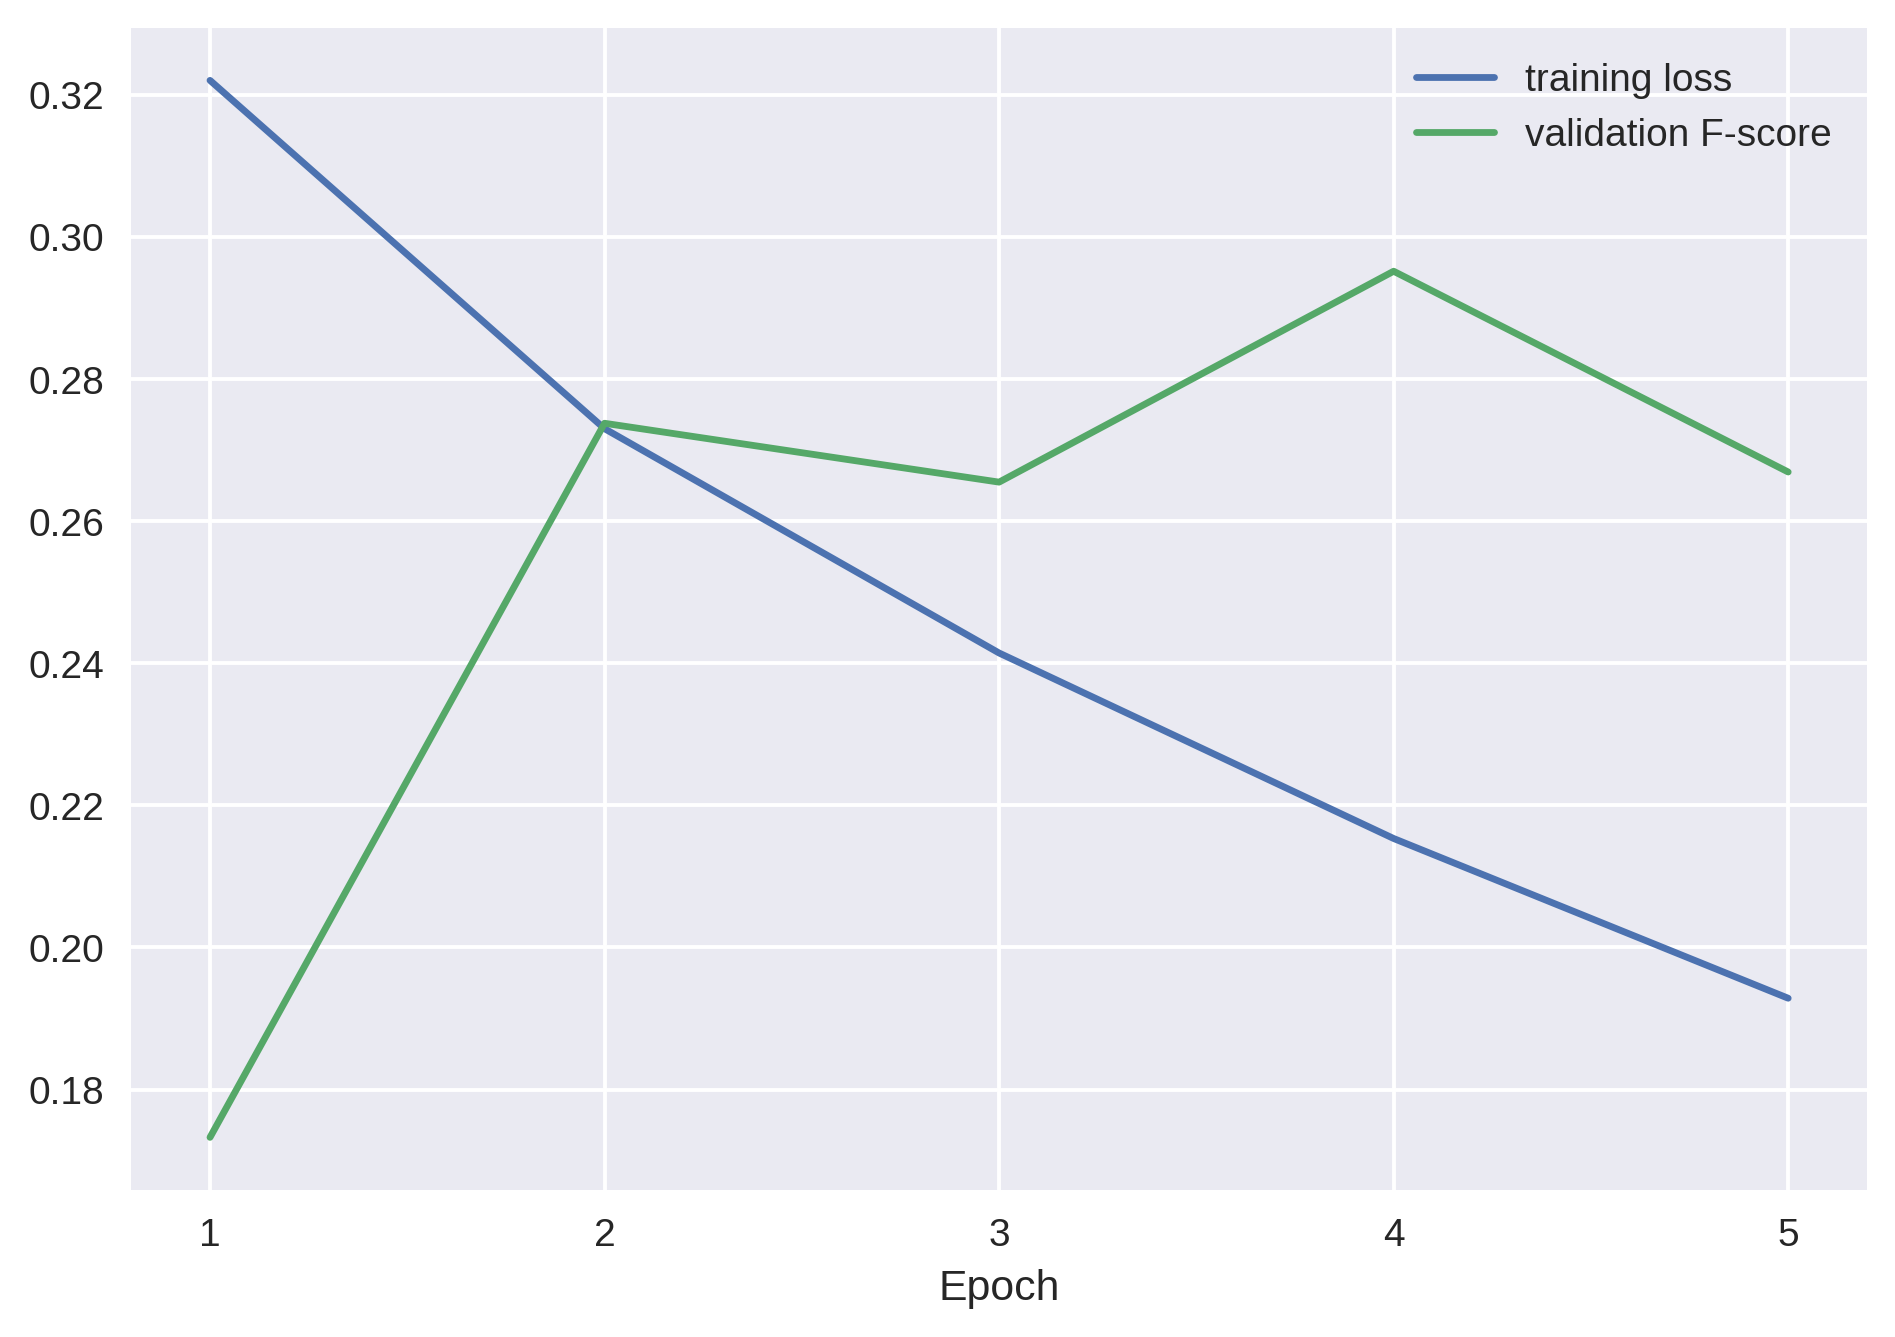

In [ ]:
# SI setup
bert_model_name = None#"distilbert-base-uncased"

gensim_model = glove_model if not bert_model_name else None

si_conf = SpanIdentifierConfig(
    default_emb_dim=100,
    finetune_w_emb=True,
    n_epochs=5 if gensim_model else 10,
    rnn_depth=1 if not bert_model_name else 0,
    rnn_size=32,
    rnn_dropout_prob=0.2,
    word_dropout_prob=0.2,
    embedding_dropout_prob=0.2,
    use_mcdrop=False,
    max_len=160,
    si_hidden_layers=(),
    si_dropout_prob=0.2,
    predict_threshold=0.4,
    predict_quantile=0.5,
)
span_identifier_glove = SpanIdentifier(si_conf, gensim_model, bert_model_name)

# Train
torch.cuda.empty_cache()
span_identifier_glove.train(progress=True)
#glove_no_mcdrop_predict_max = span_identifier_glove.finetune_f1_score(
#    dataset_name="dev",
#    init_points=0,
#    n_iter=18,
#    finetune_quantile=False,
#)
#glove_mcdrop_predict_max = span_identifier_glove.finetune_f1_score(
#    dataset_name="dev",
#    init_points=0,
#    n_iter=18,
#    finetune_quantile=True,
#)
torch.cuda.empty_cache();

Lowercased BERT model? True



Reading and tokenizing...



Read 16673 train sentences, truncated 4.



Read 3177 dev sentences, truncated 0.
Loading Bert...



done.


Epoch  1: train loss = 0.3051, val f1: 0.2567, time = 47.5459
Epoch  2: train loss = 0.2667, val f1: 0.2886, time = 51.6251
Epoch  3: train loss = 0.2438, val f1: 0.3390, time = 53.1585
Epoch  4: train loss = 0.2199, val f1: 0.3148, time = 52.7644
Epoch  5: train loss = 0.1977, val f1: 0.3270, time = 52.9891
Epoch  6: train loss = 0.1727, val f1: 0.3538, time = 52.7631
Epoch  7: train loss = 0.1514, val f1: 0.3588, time = 52.8288
Epoch  8: train loss = 0.1355, val f1: 0.3571, time = 52.8462
Epoch  9: train loss = 0.1258, val f1: 0.3301, time = 52.9116
Epoch 10: train loss = 0.1122, val f1: 0.3622, time = 52.8748


Best result on the validation set (epoch 10):
Overall: P = 0.3662, R = 0.3583, F1 = 0.3622


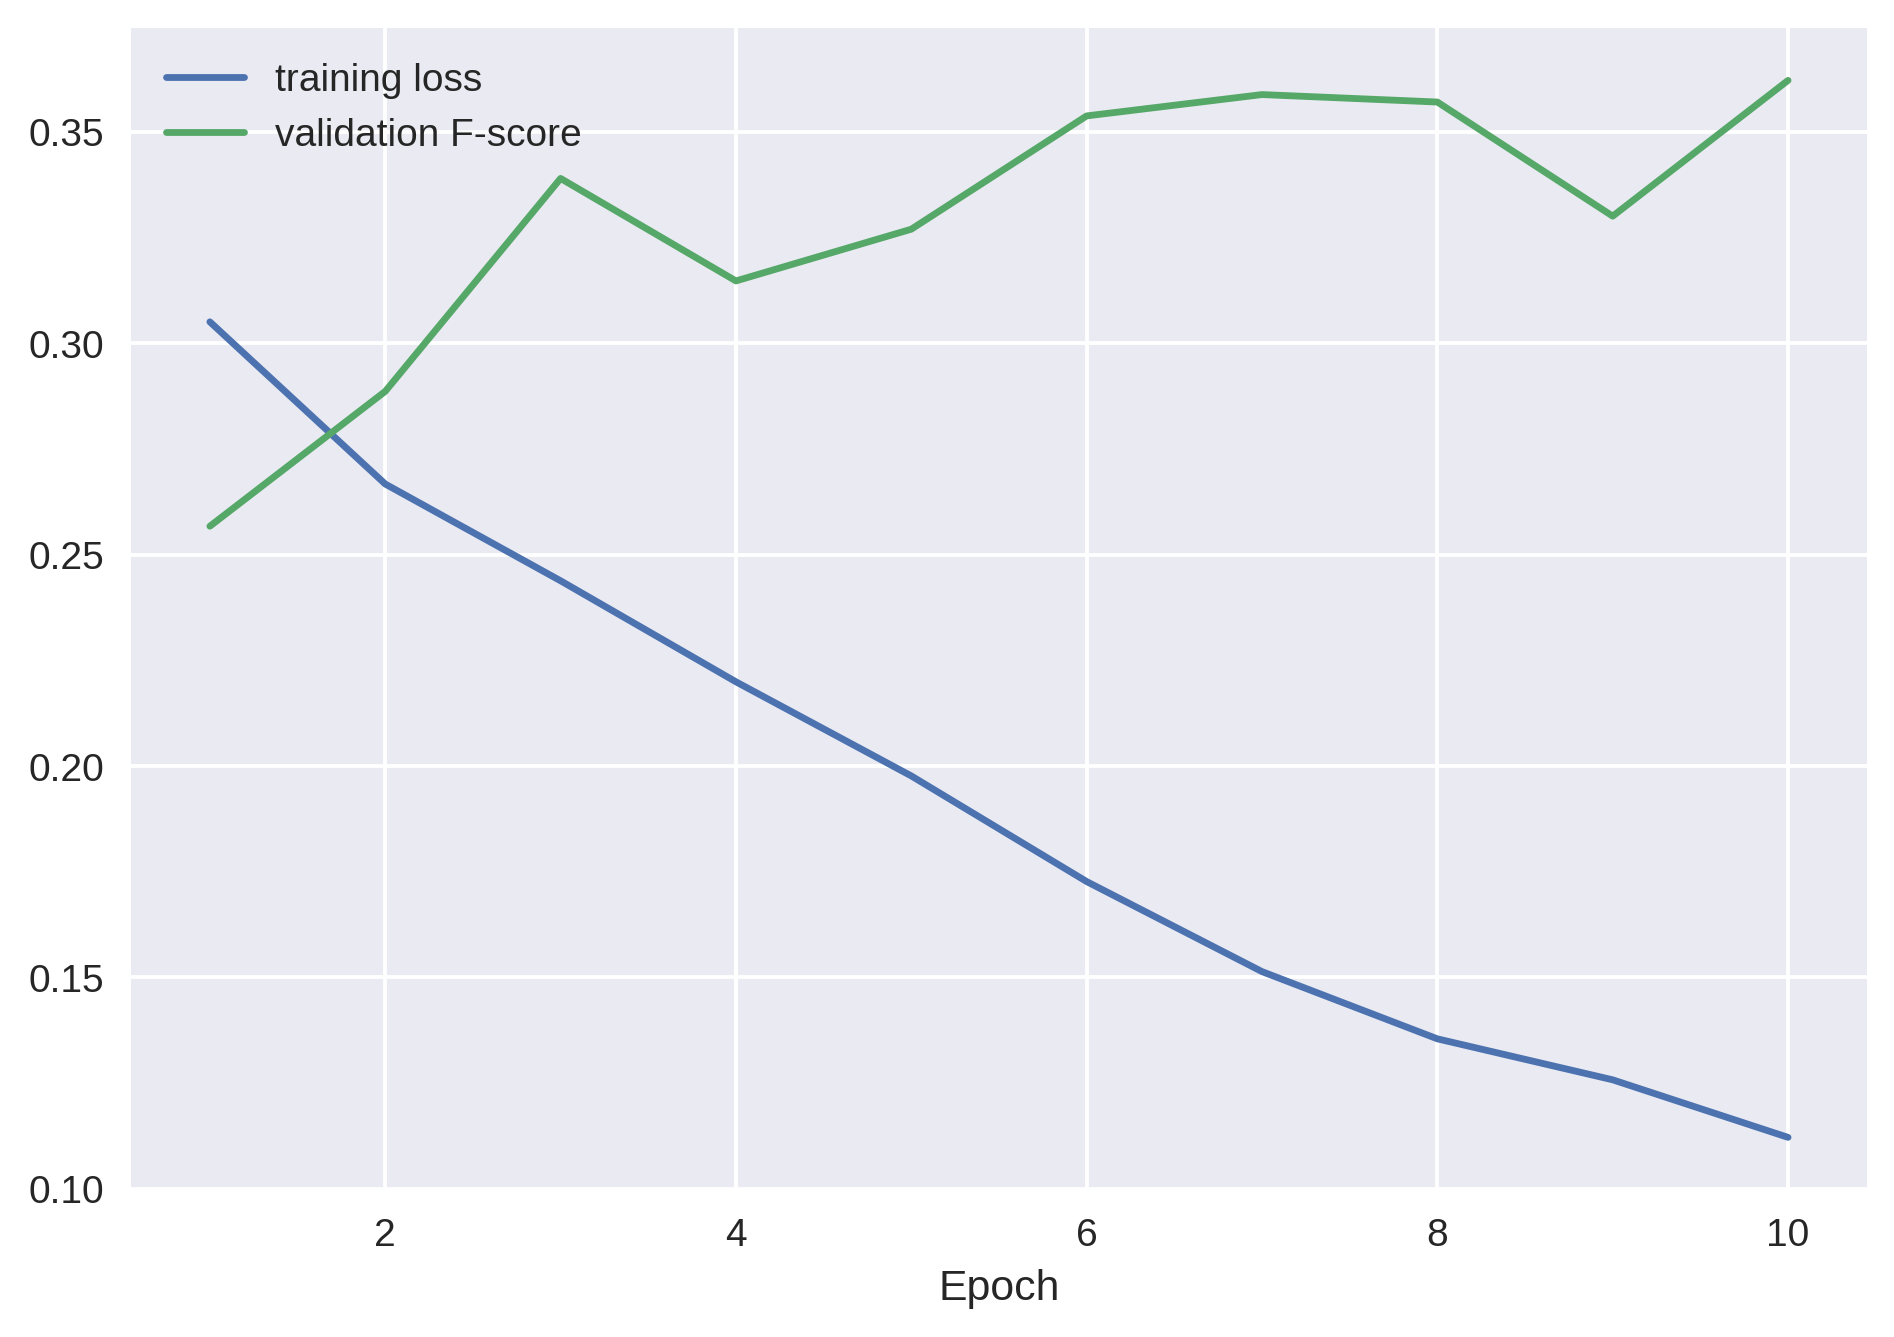

In [ ]:
# SI setup
bert_model_name = "distilbert-base-uncased"

gensim_model = glove_model if not bert_model_name else None

si_conf = SpanIdentifierConfig(
    default_emb_dim=100,
    finetune_w_emb=True,
    n_epochs=5 if gensim_model else 10,
    rnn_depth=1 if not bert_model_name else 0,
    rnn_size=32,
    rnn_dropout_prob=0.2,
    word_dropout_prob=0.2,
    embedding_dropout_prob=0.2,
    use_mcdrop=False,
    max_len=160,
    si_hidden_layers=(),
    si_dropout_prob=0.2,
    predict_threshold=0.4,
    predict_quantile=0.5,
)
span_identifier_bert = SpanIdentifier(si_conf, gensim_model, bert_model_name)

# Train
torch.cuda.empty_cache()
span_identifier_bert.train(progress=True)
#bert_no_mcdrop_predict_max = span_identifier_bert.finetune_f1_score(
#    dataset_name="dev",
#    init_points=0,
#    n_iter=18,
#    finetune_quantile=False,
#)
#bert_mcdrop_predict_max = span_identifier_bert.finetune_f1_score(
#    dataset_name="dev",
#    init_points=0,
#    n_iter=18,
#    finetune_quantile=True,
#)
torch.cuda.empty_cache();

### Save SI files

In [ ]:
use_quantile = False
if use_quantile:
    predict_kwargs = dict(
        use_mcdrop = True,
        n_evaluations = 50,
    )
    #glove_max_param = glove_mcdrop_predict_max["params"]
    #span_identifier_glove.predict_threshold = glove_max_param["predict_threshold"]
    #span_identifier_glove.predict_quantile = glove_max_param["predict_quantile"]
    #bert_max_param = bert_mcdrop_predict_max["params"]
    #span_identifier_bert.predict_threshold = bert_max_param["predict_threshold"]
    #span_identifier_bert.predict_quantile = bert_max_param["predict_quantile"]
else:
    predict_kwargs = dict(
        use_mcdrop = False,
    )
    #glove_max_param = glove_no_mcdrop_predict_max["params"]
    #span_identifier_glove.predict_threshold = glove_max_param["predict_threshold"]
    #bert_max_param = bert_no_mcdrop_predict_max["params"]
    #span_identifier_bert.predict_threshold = bert_max_param["predict_threshold"]

for span_identifier in [span_identifier_glove, span_identifier_bert]:
    span_identifier.save_to_file("train", **predict_kwargs);
    span_identifier.save_to_file("dev", **predict_kwargs);
    span_identifier.save_to_file("test", test_data=True, **predict_kwargs);

Reading and tokenizing...



Read 16673 train sentences, truncated 0.
done.
Evaluating on data...
done.
Achieved P=0.8230, R=0.7008, F1=0.7570.
Reading and tokenizing...



Read 3177 dev sentences, truncated 0.
done.
Evaluating on data...
done.
Achieved P=0.2855, R=0.2506, F1=0.2669.
Reading and tokenizing...



Read 3185 test sentences, truncated 0.
done.
Evaluating on data...
done.
Reading and tokenizing...



Read 16673 train sentences, truncated 4.
done.
Evaluating on data...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:423: UserWarning: Negative span_start set to sentence start.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:430: UserWarning: Negative span_stop set to sentence end.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:426: UserWarning: Negative span_start set to previous positive value.


done.
Achieved P=0.8796, R=0.8904, F1=0.8850.
Reading and tokenizing...



Read 3177 dev sentences, truncated 0.
done.
Evaluating on data...
done.
Achieved P=0.3662, R=0.3583, F1=0.3622.
Reading and tokenizing...



Read 3185 test sentences, truncated 0.
done.
Evaluating on data...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:426: UserWarning: Negative span_start set to previous positive value.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:430: UserWarning: Negative span_stop set to sentence end.


done.


In [ ]:
!ls
!for file in train-label-si_0?; do echo $file; python3 propaganda-techniques-scorer/task-SI_scorer.py -s $file -r datasets/train-labels-task-si; done
!for file in dev-label-si_0?; do echo $file; python3 propaganda-techniques-scorer/task-SI_scorer.py -s $file -r datasets/dev-labels-task-si; done

baseline-output-SI.txt	dev-label-si_00		      test-label-si_01
baseline-output-TC.txt	dev-label-si_01		      tools.tgz
baselines.tgz		propaganda-techniques-scorer  train-label-si_00
baseline-task-SI.py	ptc-corpus.tgz		      train-label-si_01
baseline-task-TC.py	sample_data
datasets		test-label-si_00
train-label-si_00
2021-02-08 16:08:47,912 - INFO - Checking user submitted file
2021-02-08 16:08:48,069 - INFO - Scoring the submission with precision and recall method
2021-02-08 16:08:50,299 - INFO - Precision=3779.629424/5382=0.702272	Recall=2776.415053/5397=0.514437
2021-02-08 16:08:50,299 - INFO - F1=0.593855
train-label-si_01
2021-02-08 16:08:50,404 - INFO - Checking user submitted file
2021-02-08 16:08:50,472 - ERROR - In article 700461600, the span [4426,4426] overlap with the following one from the same article: [4209,4426]
2021-02-08 16:08:50,472 - INFO - Error in submission file
dev-label-si_00
2021-02-08 16:08:50,679 - INFO - Checking user submitted file
2021-02-08 16:08:50,697 

In [ ]:
#!rm *-label-si_0*

### Some example sentences

['take our poll - story continues below\n', 'You may opt out at anytime.\n', 'pic.twitter.com/mGHOzsN6Pp — S. Lee Merritt, Esq.\n', '(@MeritLaw) September 17, 2018\n', 'Article posted with permission from John Vibes.\n', '“I think I did the right thing.\n', 'I defended the Constitution.”\n', 'That’s very different.\n', 'Tom Dodge/The Columbus Dispatch via AP\n', 'He is expected to survive, police said.\n', 'He has not yet entered a plea.\n', 'Tom Dodge/The Columbus Dispatch via AP\n', 'Tom Dodge/The Columbus Dispatch via AP\n', 'Sam Greene/Cincinnati Enquirer via USA TODAY\n', 'Sam Greene/Cincinnati Enquirer via USA TODAY\n', 'Morelli, 54, was a 29-year veteran of the department.\n', 'Westerville Police Department\n', 'Joering, 39, was a 16-year veteran of the department.\n', 'Westerville Police Department\n', 'This is a true tragedy!\n', '— Donald J. Trump (@realDonaldTrump) February 11, 2018\n', '(1/2) — John Kasich (@JohnKasich) February 10, 2018\n', 'No cop, anywhere, \'signed up\'

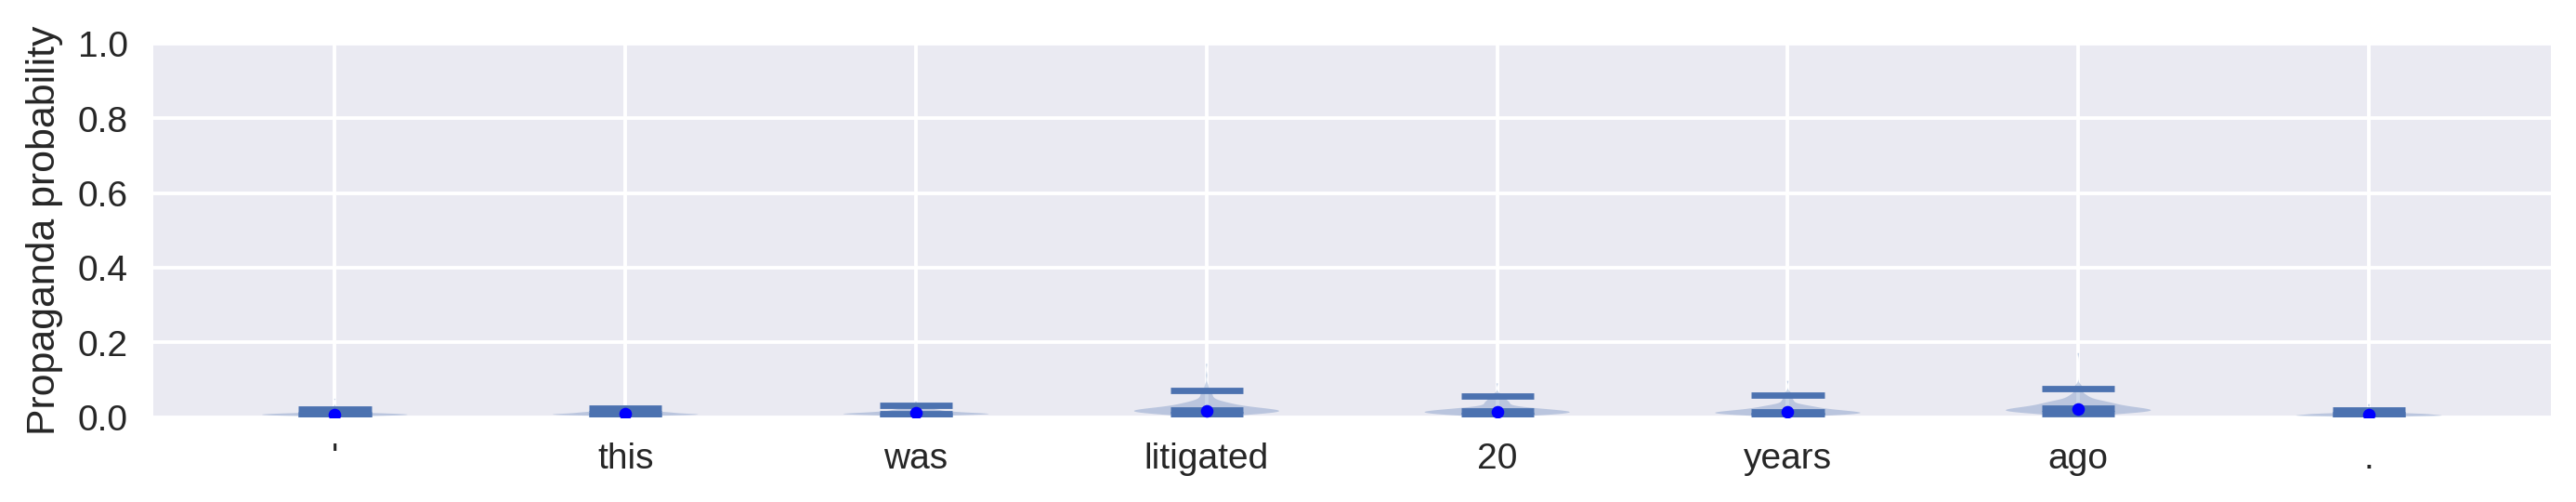

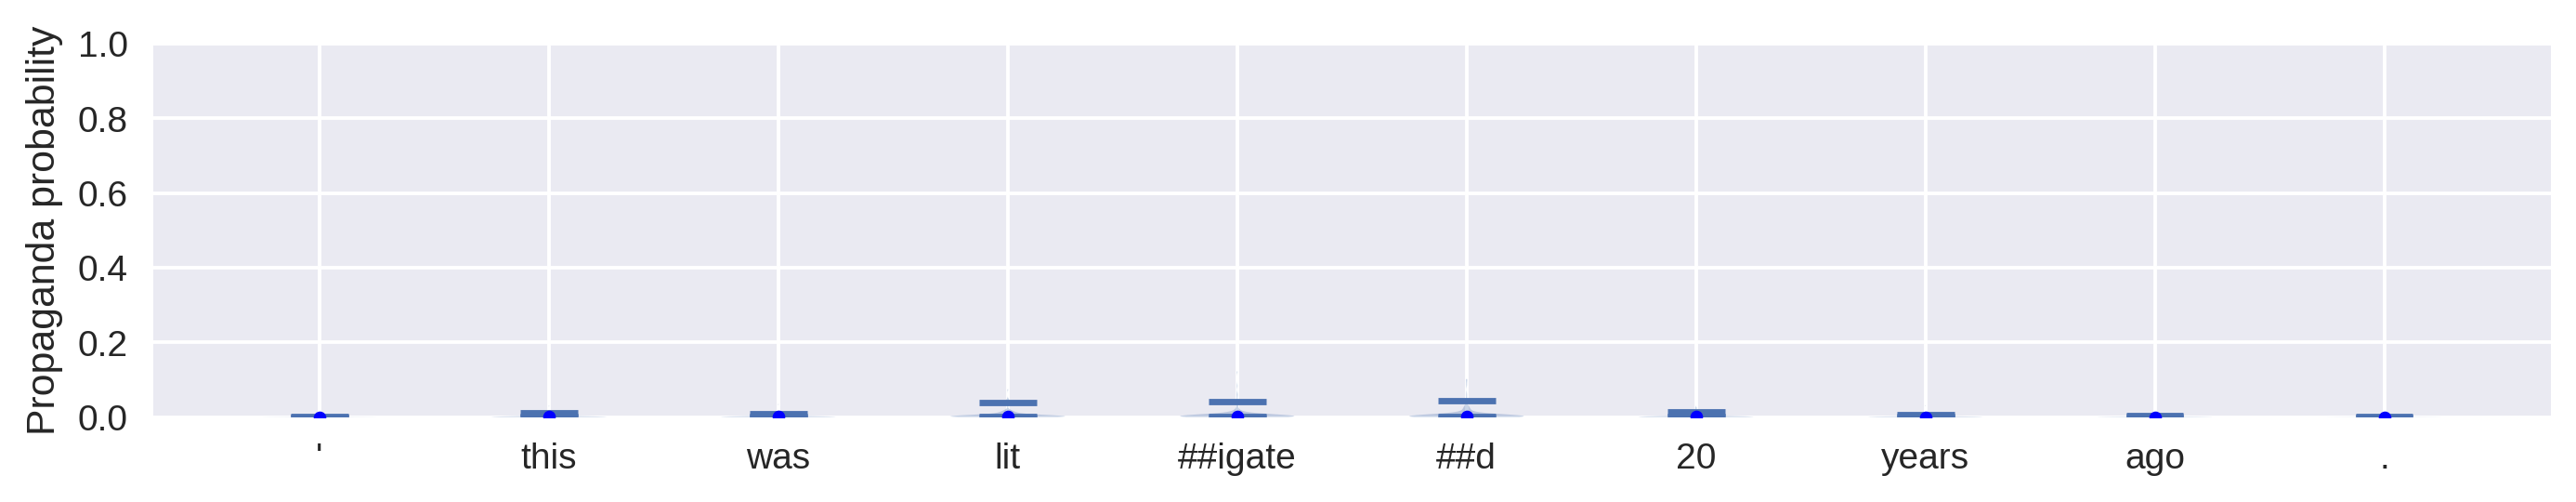

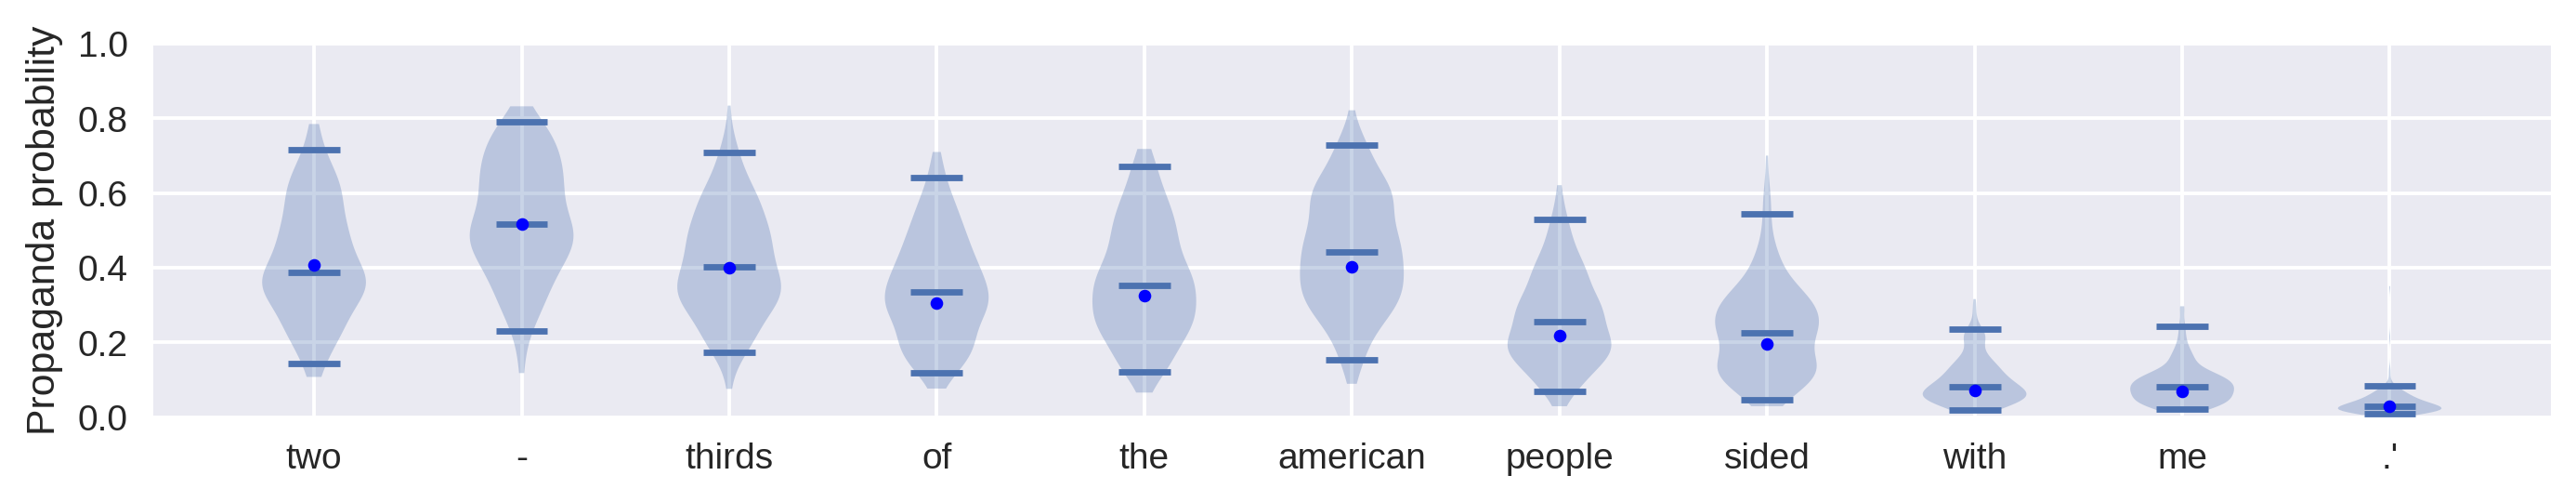

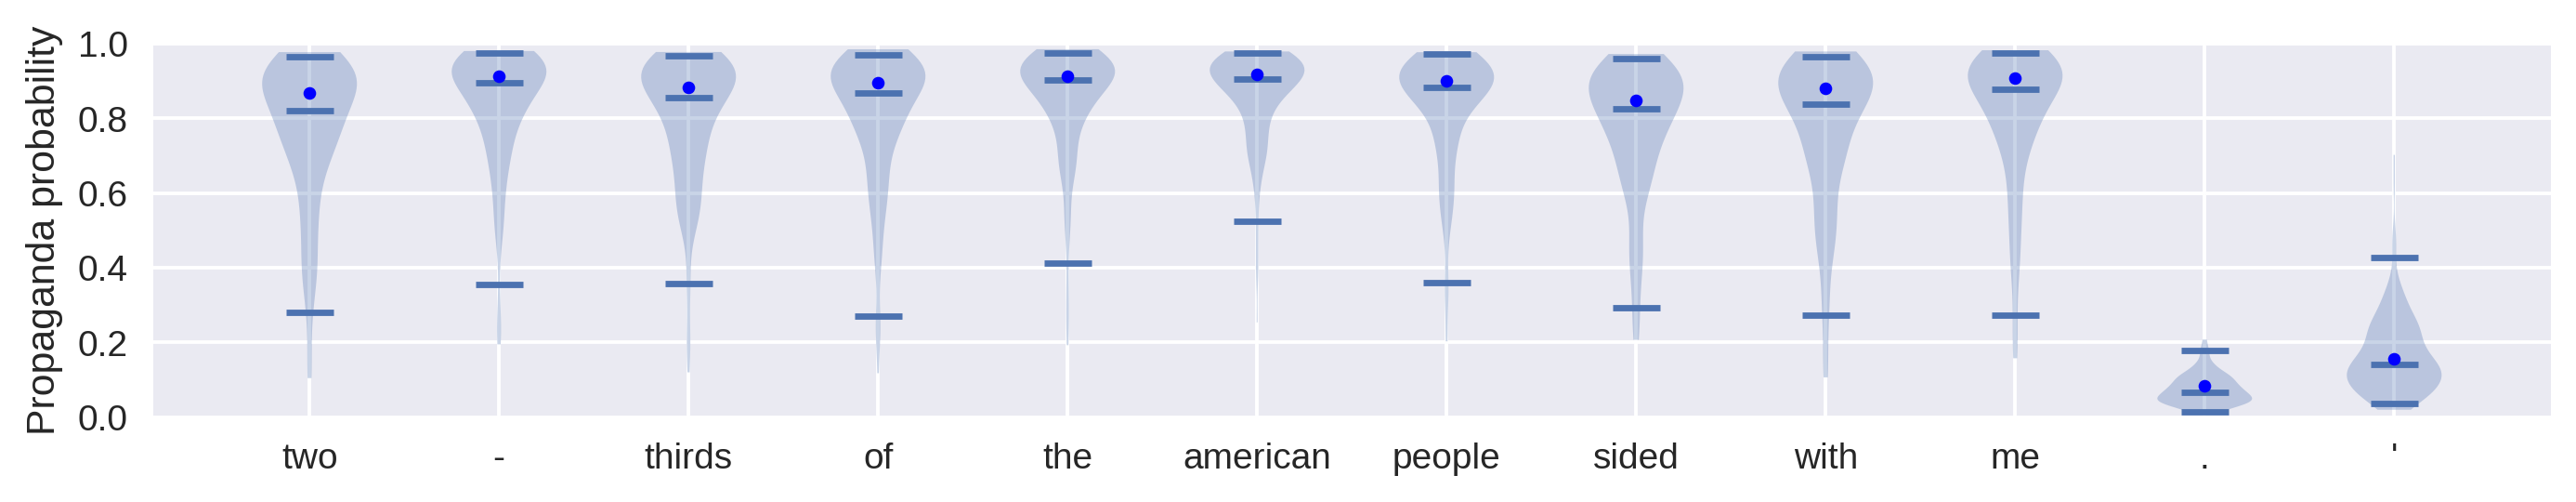

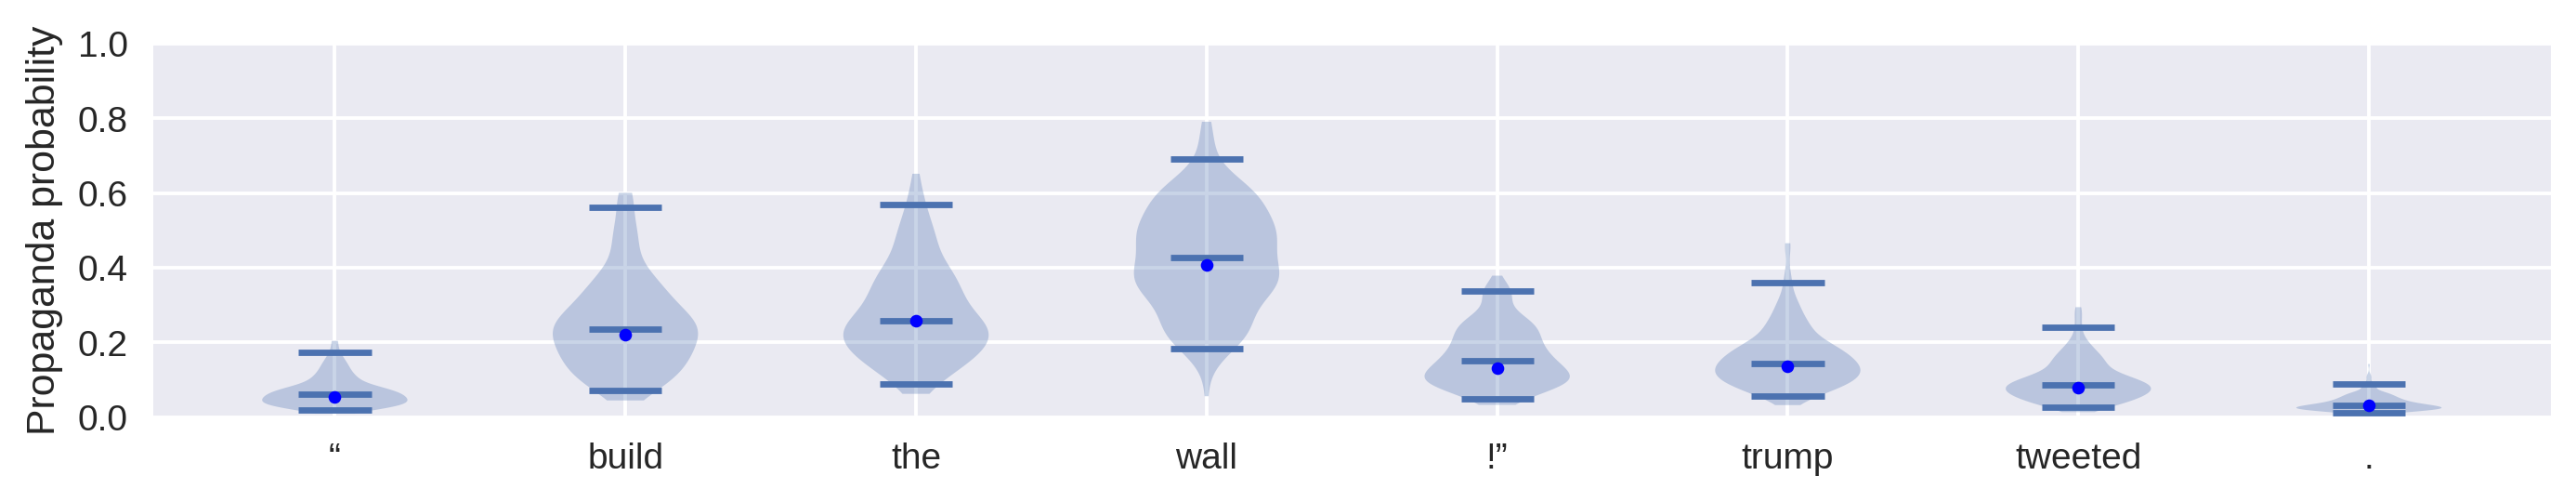

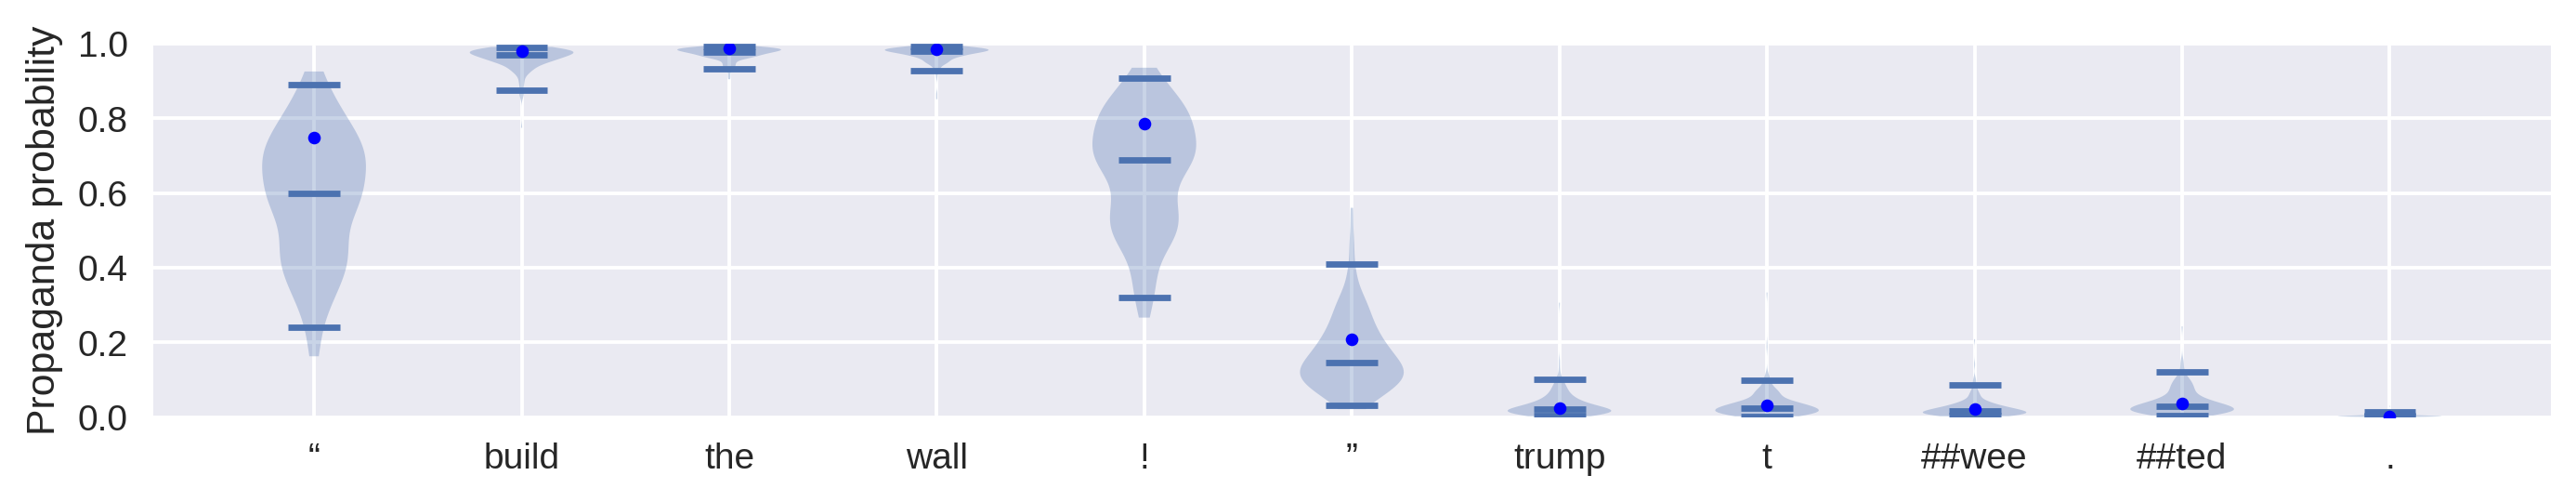

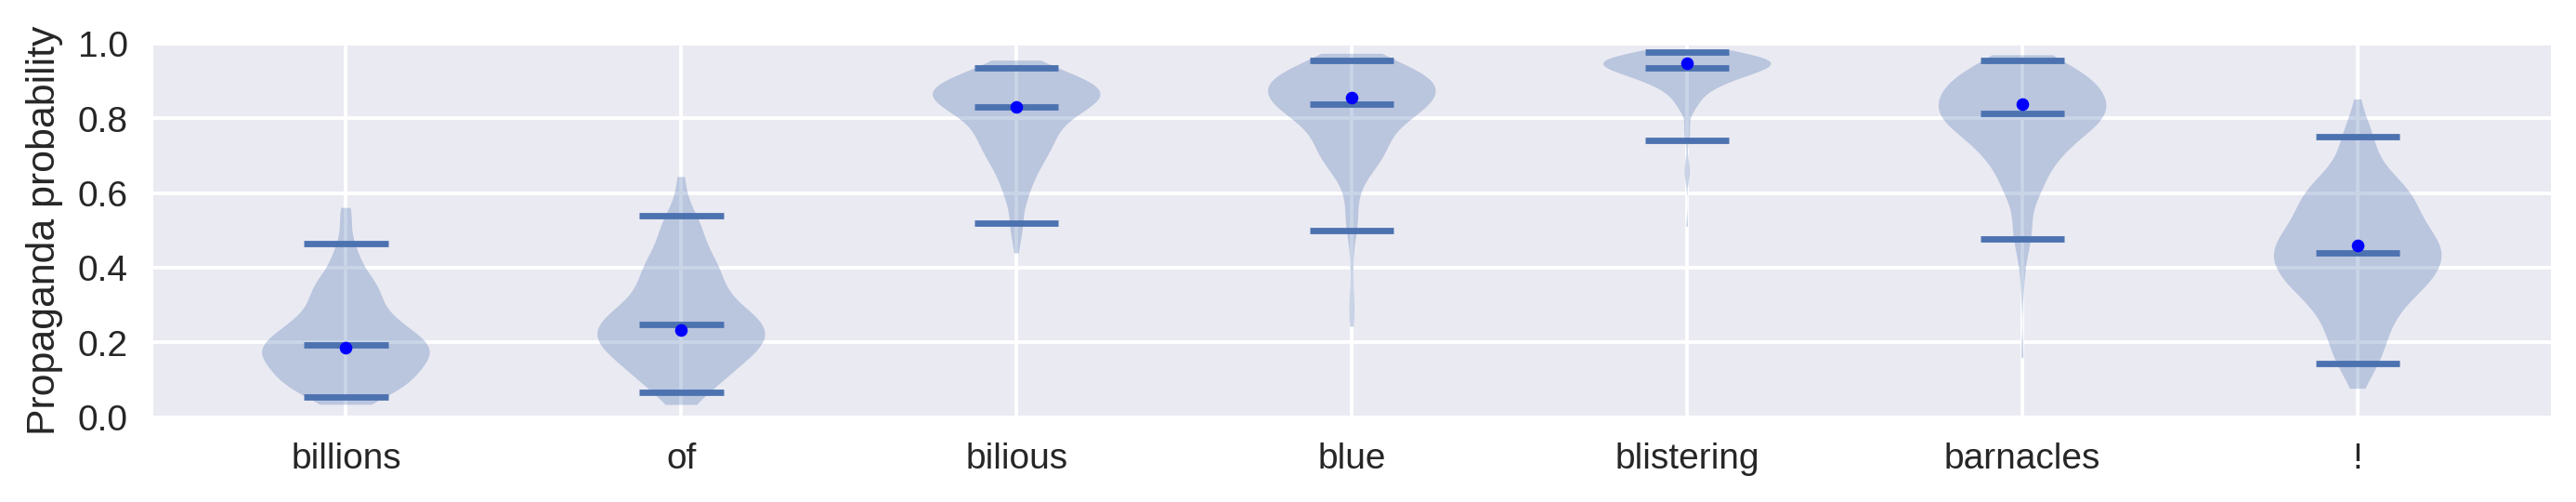

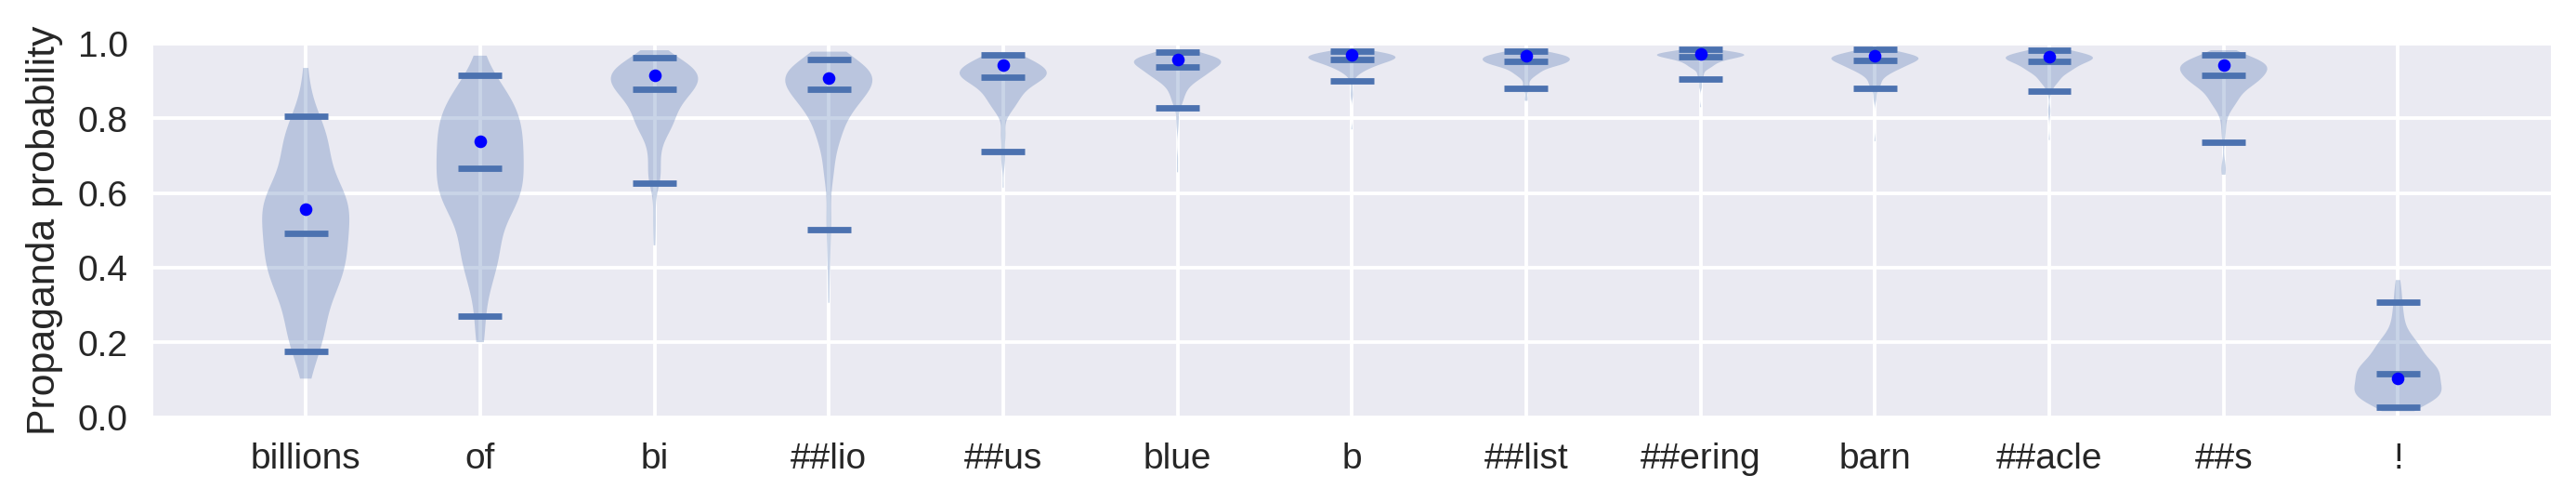

In [ ]:
def evaluate_sentence(span_identifier, sentence, n_mc_evaluations=10, **subplots_kwargs):
    # Tokenize sentence
    base_tokenizer = WordPunctTokenizer()
    if span_identifier.lowercase:
        sentence = sentence.lower()
    si_tokenize = span_identifier.tokenizer.tokenize if span_identifier else lambda sentence: sentence.split() 
    tokenized_sentence = [
        token
        for base_token in base_tokenizer.tokenize(sentence)
        for token in si_tokenize(base_token)
    ]
    n_words = len(tokenized_sentence)
    
    # MC sampling
    expected_output, mc_outputs = span_identifier.mc_evaluate([tokenized_sentence], n_mc_evaluations)
    # mc_outputs have shape [n_sentences, n_words, n_samples]

    # Plotting
    fig, ax = plt.subplots(**subplots_kwargs)
    positions = np.arange(n_words)
    ax.plot(positions, expected_output.squeeze(), ".b", zorder=10)
    ax.violinplot(
        mc_outputs.squeeze().T,
        positions,
        showextrema=False,
        #showmeans=True,
        quantiles=[(0.025, 0.5, 0.975) for i in range(n_words)],
    )

    # Fix axes
    ax.set_ylim([0, 1])
    ax.set_ylabel("Propaganda probability")
    ax.set_xticks(positions)
    ax.set_xticklabels(tokenized_sentence)
    #ax.set_xlabel("Token")

    return fig, ax

viable_sentences = []
for article_name in glob("datasets/dev-articles/article*.txt"):
    with open(article_name, mode="r", encoding="utf-8") as article:
        viable_sentences.extend([
            sentence for sentence in article.readlines() if 2 < len(sentence.split()) < 10
        ])

print(viable_sentences)
for sentence in [
    "'This was litigated 20 years ago.",
    "Two-thirds of the American people sided with me.'",
    "“BUILD THE WALL!” Trump tweeted.",
    "Billions of bilious blue blistering barnacles!",
]:
    for si_name, span_identifier in [
        ("GloVe", span_identifier_glove),
        ("BERT", span_identifier_bert),
    ]:
        fig, ax = evaluate_sentence(span_identifier, sentence, 200, figsize=(10, 2));
        sentence_id = "litigated" if "litigated" in sentence else "american" if "American" in sentence else None
        fig.tight_layout()
        if sentence_id:
            fig.savefig(f"{sentence_id}_{si_name.lower()}.pdf", bbox_inches="tight")
